## 1. Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot
init_notebook_mode (connected=True)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import plotly.io as pio
pio.renderers.default='notebook'
from IPython.display import Image

## 2. Loading Dataset

In [2]:
df=pd.read_csv('Covid-19_Dataset.csv')

In [3]:
df.head(2)

,id,case_in_country,reporting date,summary,location,country,gender,age,symptom_onset,If_onset_approximated,hosp_visit_date,exposure_start,exposure_end,visiting Wuhan,from Wuhan,death,recovered,symptom,source,link
0,765,15.0,02-10-20,new confirmed COVID-19 patient in Vietnam: 3 m...,Vinh Phuc,Vietnam,NaN,0.25,NaN,NaN,NaN,NaN,NaN,0,0,0,1,NaN,Vietnam News,https://vietnamnews.vn/society/591803/viet-nam...
1,477,27.0,02-05-20,new confirmed COVID-19 patient in Singapore: m...,Singapore,Singapore,male,0.50,NaN,NaN,NaN,1/23/2020,02-03-20,0,0,0,1,NaN,Straits Times,https://www.straitstimes.com/singapore/health/...


In [4]:
df.shape

(1085, 20)

In [5]:
df.dtypes

id                         int64
case_in_country          float64
reporting date            object
summary                   object
location                  object
country                   object
gender                    object
age                      float64
symptom_onset             object
If_onset_approximated    float64
hosp_visit_date           object
exposure_start            object
exposure_end              object
visiting Wuhan             int64
from Wuhan                 int64
death                      int64
recovered                  int64
symptom                   object
source                    object
link                      object
dtype: object

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1085 entries, 0 to 1084
Data columns (total 20 columns):
id                       1085 non-null int64
case_in_country          888 non-null float64
reporting date           1084 non-null object
summary                  1080 non-null object
location                 1085 non-null object
country                  1085 non-null object
gender                   902 non-null object
age                      843 non-null float64
symptom_onset            563 non-null object
If_onset_approximated    560 non-null float64
hosp_visit_date          507 non-null object
exposure_start           128 non-null object
exposure_end             341 non-null object
visiting Wuhan           1085 non-null int64
from Wuhan               1085 non-null int64
death                    1085 non-null int64
recovered                1085 non-null int64
symptom                  270 non-null object
source                   1085 non-null object
link                     1085 

## 3. Data Cleaning

First we remove unnecessary columns.

In [7]:
df.drop(['id','case_in_country','summary','symptom_onset', 'If_onset_approximated', 'hosp_visit_date', 'exposure_start',
'exposure_end', 'symptom', 'source', 'link'],axis=1,inplace=True)

Next we create a dataframe that shows the percentage of null values in each column of df.

In [8]:
100*df.isnull().sum()/df.shape[0]

reporting date     0.092166
location           0.000000
country            0.000000
gender            16.866359
age               22.304147
visiting Wuhan     0.000000
from Wuhan         0.000000
death              0.000000
recovered          0.000000
dtype: float64

Now we select the columns that contain between 0.5% and 70% null values, and replace the null values with the mean (for numerical columns) or median (for categorical columns) of each column.

In [9]:
df['age']= df['age']. fillna(df['age'].mean())

In [10]:
df_dum=pd.get_dummies(df['gender'].dropna(), drop_first=True)

In [11]:
df_dum['male'].median()

1.0

So we fill the null values in gender column with 'male'.

In [12]:
df['gender']= df['gender']. fillna('male')

Fianlly the columns that contain less than 0.5% null values are remained, and we drop the rows of df that contain these null values.

In [13]:
df.dropna(inplace=True)

In [14]:
df.isnull().sum()

reporting date    0
location          0
country           0
gender            0
age               0
visiting Wuhan    0
from Wuhan        0
death             0
recovered         0
dtype: int64

## 4. Feature Engineering

We rename some of the columns.

In [15]:
df.columns=df.columns.str.lower().str.replace(' ','_')

Now we change the format of date and add month column to df.

In [16]:
df['reporting_date']=pd.to_datetime(df['reporting_date'])

In [17]:
df['year']=df['reporting_date'].apply(lambda x:x.year)
df['month']=df['reporting_date'].apply(lambda x:x.month)

In [18]:
df['month'].unique()

array([2, 1], dtype=int64)

As there is only one year, we can remove the year column.

In [19]:
df.drop(['reporting_date', 'year'], axis=1, inplace=True)

In [20]:
df.head(2)

,location,country,gender,age,visiting_wuhan,from_wuhan,death,recovered,month
0,Vinh Phuc,Vietnam,male,0.25,0,0,0,1,2
1,Singapore,Singapore,male,0.50,0,0,0,1,2


## 5. Exploratory Data Analysis

We want to find the number of patients died and recovered based on their age.

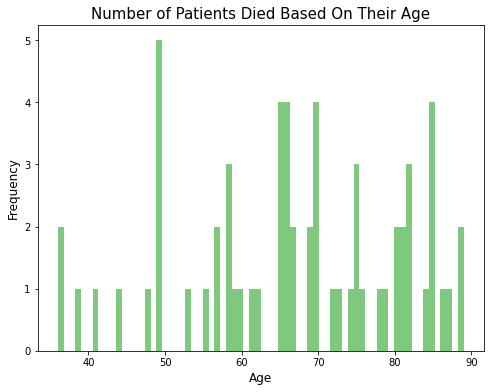

In [21]:
plt.figure(figsize=(8,6))
df[df['death']==1]['age'].plot(kind='hist',bins=70,colormap='Accent')
plt.title('Number of Patients Died Based On Their Age',fontsize=15)
plt.xlabel('Age',fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.show()

We can conclude that Pateints with age more than 48 have higher chance of death because of their weaker immune system.

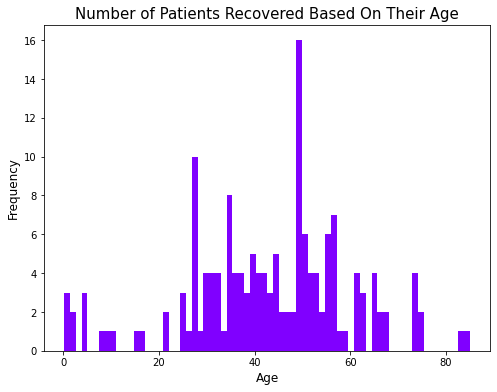

In [22]:
plt.figure(figsize=(8,6))
df[df['recovered']==1]['age'].plot(kind='hist',bins=70,colormap='rainbow')
plt.title('Number of Patients Recovered Based On Their Age',fontsize=15)
plt.xlabel('Age',fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.show()

Patients with age of 50 or lower have higher chance of recovery.

We calculate the current number of patients, those who recovered, diad, or those who arer receiving treatment.

In [23]:
print('Current count of patients:',df['death'].count())
print('Number of Dead Patients:', df[df['death']==1]['death'].count())
print('Number of Recovered Patients:',df[df['recovered']==1]['death'].count())
print('Number of Patients Receiving Treatment:',df[(df['death']==0)&(df['recovered']==0)]['death'].count())

Current count of patients: 1084
Number of Dead Patients: 63
Number of Recovered Patients: 159
Number of Patients Receiving Treatment: 862


We create bar plots for recovered and dead patients and categorize them versus gender.

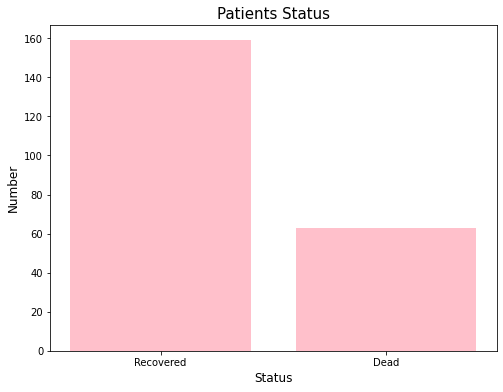

In [24]:
plt.figure(figsize=(8,6))
plt.bar(x=['Recovered','Dead'],height=[159,63], color='pink')
plt.title('Patients Status',fontsize=15)
plt.xlabel('Status', fontsize=12)
plt.ylabel('Number',fontsize=12)
plt.show()

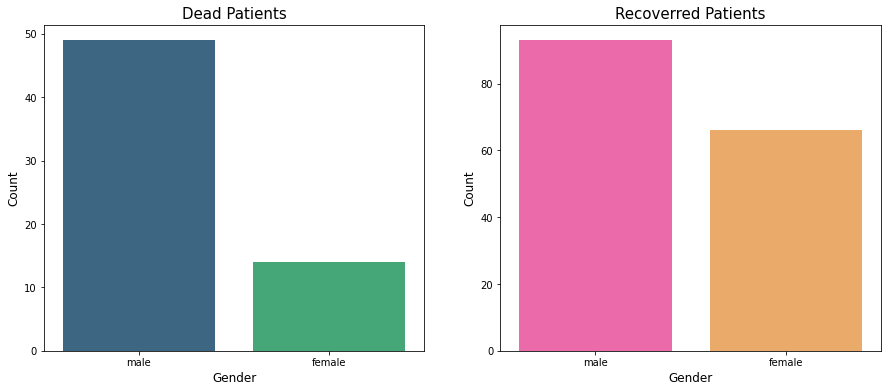

In [25]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.countplot(x='gender', data=df[df['death']==1], palette='viridis')
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Dead Patients',fontsize=15)
plt.subplot(1,2,2)
sns.countplot(x='gender', data=df[df['recovered']==1], palette='spring')
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Recoverred Patients',fontsize=15)
plt.show()

Most of both dead and recovered patients were male.

We create bar plots for recovered and dead patients and categorize them versus they are from wuhan or not from wuhan.

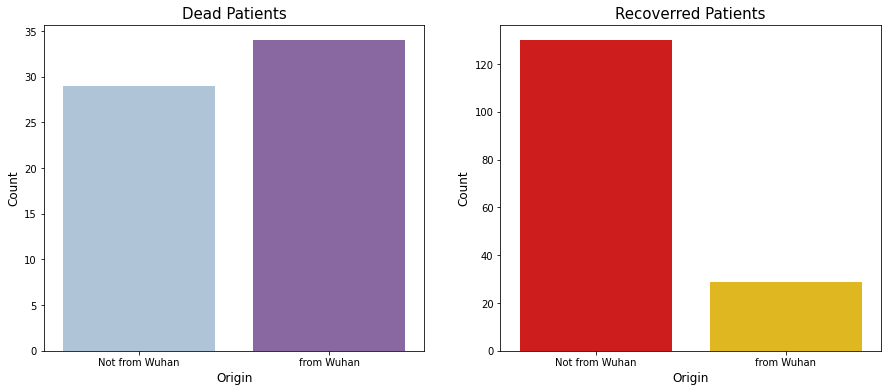

In [26]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.countplot(x='from_wuhan', data=df[df['death']==1], palette='BuPu')
plt.xticks([0,1], ['Not from Wuhan','from Wuhan'])
plt.xlabel('Origin', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Dead Patients',fontsize=15)
plt.subplot(1,2,2)
sns.countplot(x='from_wuhan', data=df[df['recovered']==1], palette='hot')
plt.xticks([0,1], ['Not from Wuhan','from Wuhan'])
plt.xlabel('Origin', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Recoverred Patients',fontsize=15)
plt.show()

Patients from Wuhan have higher chance of death and lower  chance of recovery as compared to patients not from Wuhan.

We create Countplot of number of Covid patients in different countries.

In [27]:
country_order=list(df.groupby('country').count()['location'].sort_values(ascending=False).index)

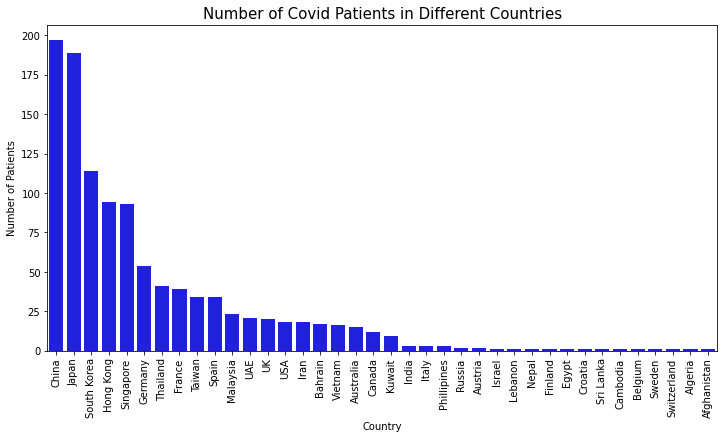

In [28]:
plt.figure(figsize=(12,6))
sns.countplot(x='country',data=df,color='blue',order=country_order)
plt.xticks(rotation=90)
plt.ylabel('Number of Patients')
plt.xlabel('Country')
plt.title('Number of Covid Patients in Different Countries',fontsize=15)
plt.show()

China and Japan have more patients as compared to others.

Let's create two world maps to demonstrate the number of death patients and recovered patients in each country.

In [29]:
groupby_df=df.groupby('country').sum()

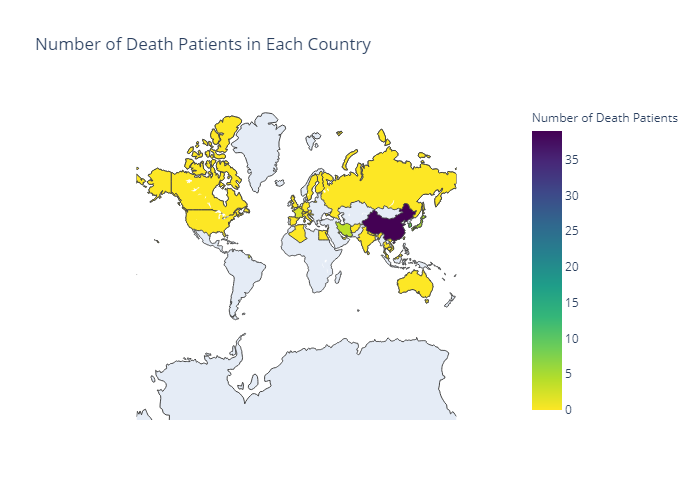

In [30]:
data=dict (type='choropleth', locations=list(groupby_df.index), locationmode='country names', colorscale='viridis', reversescale=True, text= list(groupby_df.index),z=groupby_df['death'], colorbar={'title':'Number of Death Patients'})
layout=dict(title='Number of Death Patients in Each Country', geo=dict(showframe=False, projection={'type':'mercator'}))
choromap=go.Figure(data=[data], layout=layout)
Image(pio.to_image(choromap,format='png'))

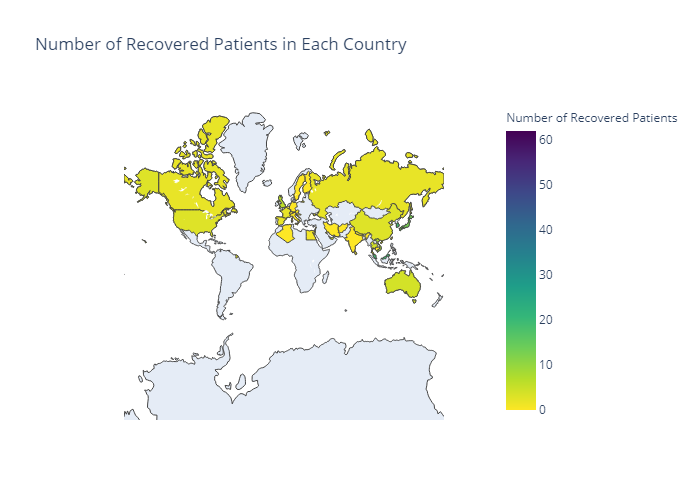

In [31]:
data=dict (type='choropleth', locations=list(groupby_df.index), locationmode='country names', colorscale='viridis', reversescale=True, text= list(groupby_df.index),z=groupby_df['recovered'], colorbar={'title':'Number of Recovered Patients'})
layout=dict(title='Number of Recovered Patients in Each Country', geo=dict(showframe=False, projection={'type':'mercator'}))
choromap=go.Figure(data=[data], layout=layout)
from IPython.display import Image
Image(pio.to_image(choromap,format='png'))

## 6. Prediction of Death or Recovery of Patients

### 6.1. Label Encoding

**Location**

In [32]:
le1=LabelEncoder()
le1.fit(df['location'])
df['location']=le1.transform(df['location'])

**Country**

In [33]:
le2=LabelEncoder()
le2.fit(df['country'])
df['country']=le2.transform(df['country'])

**Gender**

In [34]:
le3=LabelEncoder()
le3.fit(df['gender'])
df['gender']=le3.transform(df['gender'])

In [35]:
df.head()

,location,country,gender,age,visiting_wuhan,from_wuhan,death,recovered,month
0,141,37,1,0.25,0,0,0,1,2
1,118,26,1,0.50,0,0,0,1,2
2,118,26,1,1.00,0,0,0,1,2
3,42,8,0,2.00,1,0,0,0,1
4,60,22,1,2.00,0,0,0,1,1


### 6.2. Predicting the Recovery

#### 6.2.1. Splitting the Data

In [36]:
y=df['recovered']
X=df[['location','country','gender','age','visiting_wuhan','from_wuhan','month']]

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### 6.2.2. Logistic Regression

In [38]:
lr1=LogisticRegression()
lr1.fit(X,y)
predictions_lr1=lr1.predict(X_test)

C:\Users\Soha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



In [39]:
print(confusion_matrix(y_test,predictions_lr1))
print('\n')
print(classification_report(y_test,predictions_lr1))

[[183   2]
 [ 29   3]]


              precision    recall  f1-score   support

           0       0.86      0.99      0.92       185
           1       0.60      0.09      0.16        32

    accuracy                           0.86       217
   macro avg       0.73      0.54      0.54       217
weighted avg       0.82      0.86      0.81       217



#### 6.2.3. Decision Tree Classifier

In [40]:
dtc1=DecisionTreeClassifier()
dtc1.fit(X_train,y_train)
predictions_dtc1=dtc1.predict(X_test)

In [41]:
print(confusion_matrix(y_test,predictions_dtc1))
print("\n")
print(classification_report(y_test,predictions_dtc1))

[[170  15]
 [ 10  22]]


              precision    recall  f1-score   support

           0       0.94      0.92      0.93       185
           1       0.59      0.69      0.64        32

    accuracy                           0.88       217
   macro avg       0.77      0.80      0.78       217
weighted avg       0.89      0.88      0.89       217



#### 6.2.4. Random Forest Classifier

In [42]:
rfc1=RandomForestClassifier(n_estimators=200)
rfc1.fit(X_train,y_train)
predictions_rfc1=rfc1.predict(X_test)

In [43]:
print(confusion_matrix(y_test,predictions_rfc1))
print('\n')
print(classification_report(y_test,predictions_rfc1))

[[177   8]
 [ 12  20]]


              precision    recall  f1-score   support

           0       0.94      0.96      0.95       185
           1       0.71      0.62      0.67        32

    accuracy                           0.91       217
   macro avg       0.83      0.79      0.81       217
weighted avg       0.90      0.91      0.91       217



#### 6.2.5. Support Vector Classifier

In [44]:
svc1=SVC()
svc1.fit(X_train,y_train)
predictions_svc1=svc1.predict(X_test)

C:\Users\Soha\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



In [45]:
print(confusion_matrix(y_test,predictions_svc1))
print('\n')
print(classification_report(y_test,predictions_svc1))

[[182   3]
 [ 23   9]]


              precision    recall  f1-score   support

           0       0.89      0.98      0.93       185
           1       0.75      0.28      0.41        32

    accuracy                           0.88       217
   macro avg       0.82      0.63      0.67       217
weighted avg       0.87      0.88      0.86       217



To improve the results obtained by SVC, we define C and gamma parameters.

In [46]:
param_grid={'C':[0.1,1,10,100,1000], 'gamma':[1,0.1,0.01,0.001], 'kernel':['rbf']}

In [47]:
gs1=GridSearchCV(SVC(),param_grid, verbose=3)
gs1.fit(X_train,y_train)
predictions_gs1=gs1.predict(X_test)

C:\Users\Soha\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.852, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.855, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.854, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.852, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.855, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.854, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.852, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.855, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] .

[CV] ..... C=1000, gamma=0.001, kernel=rbf, score=0.847, total=   0.2s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    3.6s finished


In [48]:
print(confusion_matrix(y_test,predictions_gs1))
print('\n')
print(classification_report(y_test,predictions_gs1))

[[181   4]
 [ 18  14]]


              precision    recall  f1-score   support

           0       0.91      0.98      0.94       185
           1       0.78      0.44      0.56        32

    accuracy                           0.90       217
   macro avg       0.84      0.71      0.75       217
weighted avg       0.89      0.90      0.89       217



#### 6.2.6. XGBoost Classifier

In [49]:
xgbc1=xgb.XGBClassifier(n_estimators=200, learning_rate=0.08, gamma=0, subsample=0.5,colsample_bytree=1, max_depth=8)
xgbc1.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.08, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [50]:
predictions_xgbc1=xgbc1.predict(X_test)

In [51]:
print(confusion_matrix(y_test,predictions_xgbc1))
print('\n')
print(classification_report(y_test,predictions_xgbc1))

[[180   5]
 [ 11  21]]


              precision    recall  f1-score   support

           0       0.94      0.97      0.96       185
           1       0.81      0.66      0.72        32

    accuracy                           0.93       217
   macro avg       0.88      0.81      0.84       217
weighted avg       0.92      0.93      0.92       217



In [52]:
print('Accuracy Score, Logistic Regression: ', round(accuracy_score(y_test,predictions_lr1),ndigits=3))
print('Accuracy Score, Decision Tree Classifier: ', round(accuracy_score(y_test,predictions_dtc1),ndigits=3))
print('Accuracy Score, Random Forest Classifier: ', round(accuracy_score(y_test,predictions_rfc1),ndigits=3))
print('Accuracy Score, Support Vector Classifier: ', round(accuracy_score(y_test,predictions_gs1),ndigits=3))
print('Accuracy Score, XGBoost Classifier: ', round(accuracy_score(y_test,predictions_xgbc1), ndigits=2))

Accuracy Score, Logistic Regression:  0.857
Accuracy Score, Decision Tree Classifier:  0.885
Accuracy Score, Random Forest Classifier:  0.908
Accuracy Score, Support Vector Classifier:  0.899
Accuracy Score, XGBoost Classifier:  0.93


So we conclude that XGBoost Classifier with the accuracy of 93% is the best model for predicting the number of recovered patients.

### 6.3. Predicting the Death

#### 6.3.1. Splitting the Data

In [53]:
y=df['death']
X=df[['location','country','gender','age','visiting_wuhan','from_wuhan','month']]

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### 6.3.2. Logistic Regression

In [55]:
lr2=LogisticRegression()
lr2.fit(X,y)
predictions_lr2=lr2.predict(X_test)

C:\Users\Soha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



In [56]:
print(confusion_matrix(y_test,predictions_lr2))
print('\n')
print(classification_report(y_test,predictions_lr2))

[[200   2]
 [ 11   4]]


              precision    recall  f1-score   support

           0       0.95      0.99      0.97       202
           1       0.67      0.27      0.38        15

    accuracy                           0.94       217
   macro avg       0.81      0.63      0.67       217
weighted avg       0.93      0.94      0.93       217



#### 6.3.3. Decision Tree Classifier

In [57]:
dtc2=DecisionTreeClassifier()
dtc2.fit(X_train,y_train)
predictions_dtc2=dtc2.predict(X_test)

In [58]:
print(confusion_matrix(y_test,predictions_dtc2))
print("\n")
print(classification_report(y_test,predictions_dtc2))

[[198   4]
 [  7   8]]


              precision    recall  f1-score   support

           0       0.97      0.98      0.97       202
           1       0.67      0.53      0.59        15

    accuracy                           0.95       217
   macro avg       0.82      0.76      0.78       217
weighted avg       0.95      0.95      0.95       217



#### 6.3.4. Random Forest Classifier

In [59]:
rfc2=RandomForestClassifier(n_estimators=200)
rfc2.fit(X_train,y_train)
predictions_rfc2=rfc2.predict(X_test)

In [60]:
print(confusion_matrix(y_test,predictions_rfc2))
print('\n')
print(classification_report(y_test,predictions_rfc2))

[[202   0]
 [  8   7]]


              precision    recall  f1-score   support

           0       0.96      1.00      0.98       202
           1       1.00      0.47      0.64        15

    accuracy                           0.96       217
   macro avg       0.98      0.73      0.81       217
weighted avg       0.96      0.96      0.96       217



#### 6.3.5. Support Vector Classifier

In [61]:
svc2=SVC()
svc2.fit(X_train,y_train)
predictions_svc2=svc2.predict(X_test)

C:\Users\Soha\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



In [62]:
print(confusion_matrix(y_test,predictions_svc2))
print('\n')
print(classification_report(y_test,predictions_svc2))

[[202   0]
 [ 11   4]]


              precision    recall  f1-score   support

           0       0.95      1.00      0.97       202
           1       1.00      0.27      0.42        15

    accuracy                           0.95       217
   macro avg       0.97      0.63      0.70       217
weighted avg       0.95      0.95      0.94       217



To improve the results obtained by SVC, we define C and gamma parameters.

In [63]:
param_grid={'C':[0.1,1,10,100,1000], 'gamma':[1,0.1,0.01,0.001], 'kernel':['rbf']}

In [64]:
gs2=GridSearchCV(SVC(),param_grid, verbose=3)
gs2.fit(X_train,y_train)
predictions_gs2=gs2.predict(X_test)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.945, total=   0.1s

C:\Users\Soha\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.945, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.945, total=   0.1s

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.945, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.945, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.945, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.945, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.945, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.945, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.945, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    2.5s finished


In [65]:
print(confusion_matrix(y_test,predictions_gs2))
print('\n')
print(classification_report(y_test,predictions_gs2))

[[200   2]
 [  9   6]]


              precision    recall  f1-score   support

           0       0.96      0.99      0.97       202
           1       0.75      0.40      0.52        15

    accuracy                           0.95       217
   macro avg       0.85      0.70      0.75       217
weighted avg       0.94      0.95      0.94       217



#### 6.3.6. XGBoost Classifier

In [66]:
xgbc2=xgb.XGBClassifier(n_estimators=200, learning_rate=0.08, gamma=0, subsample=0.5,colsample_bytree=1, max_depth=8)
xgbc2.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.08, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [67]:
predictions_xgbc2=xgbc2.predict(X_test)

In [68]:
print(confusion_matrix(y_test,predictions_xgbc2))
print('\n')
print(classification_report(y_test,predictions_xgbc2))

[[201   1]
 [ 10   5]]


              precision    recall  f1-score   support

           0       0.95      1.00      0.97       202
           1       0.83      0.33      0.48        15

    accuracy                           0.95       217
   macro avg       0.89      0.66      0.72       217
weighted avg       0.94      0.95      0.94       217



In [69]:
print('Accuracy Score, Logistic Regression: ', round(accuracy_score(y_test,predictions_lr2),ndigits=3))
print('Accuracy Score, Decision Tree Classifier: ', round(accuracy_score(y_test,predictions_dtc2),ndigits=3))
print('Accuracy Score, Random Forest Classifier: ', round(accuracy_score(y_test,predictions_rfc2),ndigits=3))
print('Accuracy Score, Support Vector Classifier: ', round(accuracy_score(y_test,predictions_gs2),ndigits=3))
print('Accuracy Score, XGBoost Classifier: ', round(accuracy_score(y_test,predictions_xgbc2), ndigits=3))

Accuracy Score, Logistic Regression:  0.94
Accuracy Score, Decision Tree Classifier:  0.949
Accuracy Score, Random Forest Classifier:  0.963
Accuracy Score, Support Vector Classifier:  0.949
Accuracy Score, XGBoost Classifier:  0.949


So we conclude that Random Forest Classifier with the accuracy of 96.3% is the best model for predicting the number of dead patients.

## 7. Conclusion

-  We performed Data Cleaning and Feature Engineering to convert the dataset to an acceptable format.

-  We performed Exploratory Data Analysis and determined the factors that were more important in the death and recovery of patients

-  XGBoost Classifier with the accuracy of 93% was the best model for predicting the number of recovered patients. 

-  Random Forest Classifier with the accuracy of 96.3% was the best model for predicting the number of dead patients.